# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Leemos los datos de enero 2020 (entrenamiento)

In [2]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [4]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Descripción del Dataset

El diccionario de los datos puede encontrarse [acá](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

| Field Name      | Description |
| ----------- | ----------- |
| VendorID      | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.       |
| tpep_pickup_datetime   | The date and time when the meter was engaged.        |
| tpep_dropoff_datetime   | The date and time when the meter was disengaged.        |
| Passenger_count   | The number of passengers in the vehicle. This is a driver-entered value.      |
| Trip_distance   | The elapsed trip distance in miles reported by the taximeter.      |
| PULocationID   | TLC Taxi Zone in which the taximeter was engaged.      |
| DOLocationID   | TLC Taxi Zone in which the taximeter was disengaged      |
| RateCodeID   | The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride     |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip |
| Payment_type | A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip |
| Fare_amount | The time-and-distance fare calculated by the meter. |
| Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip. |
| Total_amount | The total amount charged to passengers. Does not include cash tips. |

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [5]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [6]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [7]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [8]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.3574348 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda:

`taxi_train = taxi_train.head(100000)`

In [9]:
taxi_train = taxi_train.head(100000)

In [10]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: user 13.1 s, sys: 31.3 ms, total: 13.1 s
Wall time: 13.2 s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [11]:
%%time
# Compute F1

preds = rfc.predict_proba(taxi_train[features])

CPU times: user 1.02 s, sys: 1.82 ms, total: 1.02 s
Wall time: 1.02 s


In [12]:
preds

array([[0.39173681, 0.60826319],
       [0.39873337, 0.60126663],
       [0.47136336, 0.52863664],
       ...,
       [0.46075988, 0.53924012],
       [0.38785552, 0.61214448],
       [0.44131876, 0.55868124]])

In [13]:
preds_labels = [p[1] for p in preds.round()]

In [14]:
preds_labels[0:10]

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [15]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.658863202733283


## Exportamos el modelo a un archivo

In [16]:
import joblib

joblib.dump(rfc, "random_forest.joblib")

['random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

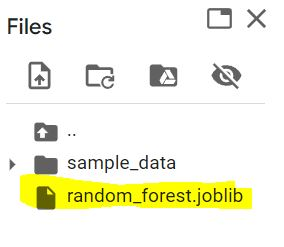

## Cargamos los datos de febrero 2020 (prueba)

In [17]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [18]:
loaded_rfc = joblib.load("random_forest.joblib")

In [19]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: user 1min 5s, sys: 2.06 s, total: 1min 7s
Wall time: 1min 12s


In [20]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.36586262266535374


## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [21]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [22]:
taxi_test.head(1)[target_col].iloc[0]

1

In [23]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5349595464170296

## Motivación: calculemos el desempeño para mayo de 2020

In [24]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test = preprocess(taxi_may, target_col=target_col)
taxi_test.head()

preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')


F1: 0.5240249946132299


#Desarrollo de una estrategia para explicar/demostrar el comportamiento distinto del modelo para cada mes de análisis.

En este análisis, evaluamos el desempeño de un modelo de clasificación RandomForest en la identificación de propinas altas en viajes de taxis amarillos de Nueva York a lo largo de todo el año 2020. El modelo, previamente entrenado con datos de enero de 2020, se evaluará mensualmente utilizando datos de cada mes del mismo año para observar cómo su desempeño varía a lo largo del tiempo.

La variable objetivo en este estudio es la propina alta, definida como una propina que excede el 20% del costo total del viaje. Utilizamos el F1-score, una métrica que combina precisión y exhaustividad, para medir la eficacia del modelo en cada mes.

El propósito de este análisis es identificar si el modelo presenta diferencias significativas en su capacidad para predecir propinas altas en diferentes meses, lo que podría ser indicativo de variaciones estacionales, cambios en los patrones de comportamiento de los pasajeros o en las condiciones del entorno.

In [27]:
import pandas as pd
from sklearn.metrics import f1_score
import joblib

# Cargamos el modelo
loaded_rfc = joblib.load("random_forest.joblib")

# Lista de meses y enlaces a los datos
months = {
    "January": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet',
    "February": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet',
    "March": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet',
    "April": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet',
    "May": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-05.parquet',
    "June": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-06.parquet',
    "July": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-07.parquet',
    "August": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-08.parquet',
    "September": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-09.parquet',
    "October": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-10.parquet',
    "November": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-11.parquet',
    "December": 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-12.parquet'
}

results = []

for month, url in months.items():
    print(f'Processing data for {month}...')
    taxi_month = pd.read_parquet(url)
    taxi_test = preprocess(taxi_month, target_col=target_col)

    # Realizamos las predicciones
    preds_test = loaded_rfc.predict_proba(taxi_test[features])
    preds_test_labels = [p[1] for p in preds_test.round()]

    # Calculamos el F1-score
    f1 = f1_score(taxi_test[target_col], preds_test_labels)
    results.append((month, f1))
    print(f'{month} F1-score: {f1}')

# Convertimos los resultados a un DataFrame para facilitar la visualización
results_df = pd.DataFrame(results, columns=['Month', 'F1-score'])
print(results_df)


Processing data for January...
January F1-score: 0.3878947526104704
Processing data for February...
February F1-score: 0.36586262266535374
Processing data for March...
March F1-score: 0.39516101182241714
Processing data for April...
April F1-score: 0.5240249946132299
Processing data for May...
May F1-score: 0.5065973501968924
Processing data for June...
June F1-score: 0.482039600895421
Processing data for July...
July F1-score: 0.48307164459568736
Processing data for August...
August F1-score: 0.4745891289360472
Processing data for September...
September F1-score: 0.4569111106042289
Processing data for October...
October F1-score: 0.4377866127006968
Processing data for November...
November F1-score: 0.4446389748390199
Processing data for December...
December F1-score: 0.4393519258094622
        Month  F1-score
0     January  0.387895
1    February  0.365863
2       March  0.395161
3       April  0.524025
4         May  0.506597
5        June  0.482040
6        July  0.483072
7      Aug

**Observaciones Clave:**


**Mejores Resultados en Primavera y Verano:** Los meses de abril y mayo presentan los F1-scores más altos, con valores de 0.5240 y 0.5066, respectivamente. Esto sugiere que el modelo ha sido más efectivo en identificar propinas altas durante estos meses.

**Desempeño Variable en Otoño e Invierno:** En contraste, los meses de enero y febrero tienen los F1-scores más bajos, 0.3879 y 0.3659, respectivamente. Esto indica un desempeño relativamente pobre en estos meses, lo que puede ser atribuido a una serie de factores como cambios en los patrones de viaje o condiciones estacionales.


**Tendencias Estacionales:** La tendencia general muestra un desempeño mejor en los meses de primavera y verano, con un leve declive en los meses de otoño e invierno. Esto podría reflejar variaciones en el comportamiento de los pasajeros o cambios en la dinámica de las tarifas durante diferentes épocas del año.

**Estabilidad Relativa Durante el Año:**A pesar de las fluctuaciones, el modelo mantiene un rango de F1-scores relativamente estable durante la mayoría del año, con una ligera disminución hacia el final del año en meses como octubre, noviembre y diciembre.

<ipython-input-28-941ba4f8f261>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='F1-score', data=results_df, palette="viridis")


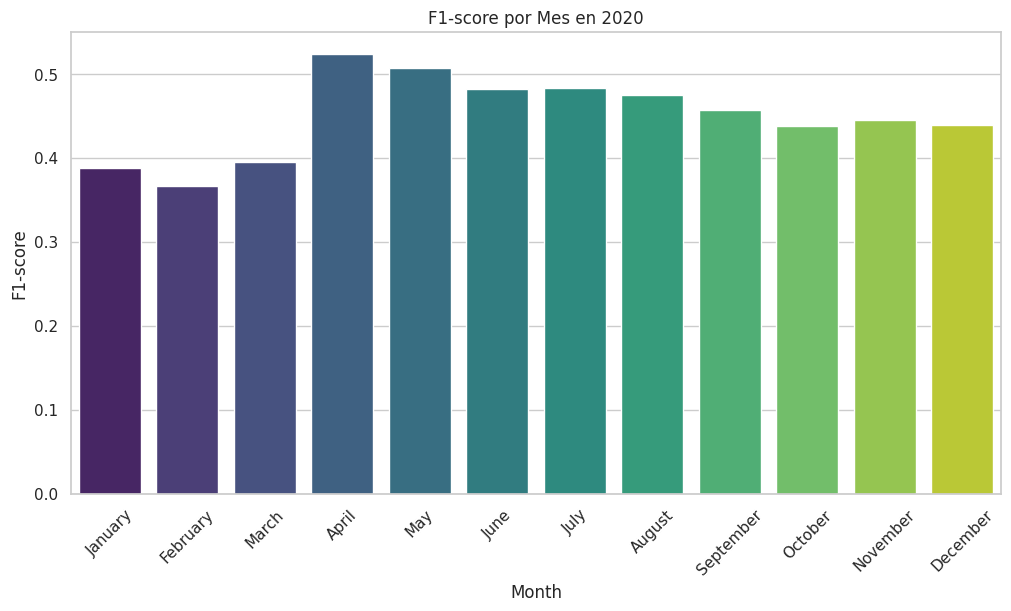

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de barras del F1-score por mes
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='F1-score', data=results_df, palette="viridis")
plt.xticks(rotation=45)
plt.title('F1-score por Mes en 2020')
plt.show()
